In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Conv2D, MaxPool2D, Flatten, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU
from keras.losses import Loss
from keras.optimizers import Optimizer
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical, plot_model, load_img, img_to_array

from keras.models import load_model

# Autoencoder: Layer Classes

In a convolutional autoencoder, the decoder must be able to take a latent representation of the input and reconstruct the original image. This requires a transformation that goes from a low-dimensional representation to a high-dimensional representation. In the decoder, upsampling and transpose convolutional layers are used to expand the feature maps back to the original size.

## Encoder

In general, a common sequence of layers for an encoder in a convolutional autoencoder is a series of Conv2D layers with a ReLU activation function, followed by a MaxPooling layer or not. Here I choose to work with the Conv2D layer follow by a BatchNormalization Layer, and a LeakyReLU Layer.

The idea when I create this Encoder class is to create a deeper or shallower encoder by adjusting the length of the filters, kernel_sizes, and pool_sizes lists. 




- **Types of ReLu operations that can be used (here I choose LeakyReLU):**

1. **ReLU**:

   - Pros:
   Simple and computationally efficient.
   Doesn't suffer from vanishing gradient problem, which can occur with other activation functions like sigmoid or tanh.

   - Cons:
   Can cause "dying ReLU" problem, where the neurons effectively "die" and output 0, which means they no longer contribute to the network's learning.
   Can be too "aggressive" in setting some neuron outputs to 0, which can cause issues if the output is actually important.

2. **LeakyReLU**:

   - Pros:
   Addresses the "dying ReLU" problem by allowing a small, non-zero output for negative inputs.
   Has similar computational efficiency to ReLU.

   - Cons:
   Can introduce some level of non-linearity that may not be desirable in some cases.

3. **Conv2D with activation function 'relu'**:

    - Pros:
    Provides non-linearity and can learn complex features.

    - Cons:
    Can be more computationally expensive than ReLU or LeakyReLU.
    Can suffer from vanishing gradient problem if the weights are not initialized properly.

**BatchNormalization**

Batch Normalization normalizes the input values (or activations) of each layer to have zero mean and unit variance. This is done on a mini-batch basis during training. It is designed to mitigate the internal covariate shift problem, which occurs when the distribution of each layer's inputs changes during training due to updates in the previous layers' parameters. This problem can slow down the training process and make it difficult to choose appropriate initializations and learning rates.

The **internal covariate shift** problem occur when a network is trained using backpropagation and gradient descent, and the changes in the parameters implies in an change in the outputs of the layers, which in turn affects the input values received by the subsequent layers. This can slow down the training process, as each layer has to constantly adapt to the changing input values. It can also make the choice of learning rate and initial parameters more critical, as the training process may become unstable if the input values change too drastically.

The BatchNormalization Layer do the following operation over the input receive from a previously layer:

1. Compute the mean and variance of the input data (or the output of the previous layer) within the mini-batch:

$$\mu_B = \frac{1}{m}\sum_{i=1}^{m}x_i$$

$$\sigma_B^2 = \frac{1}{m}\sum_{i=1}^{m}(x_i - \mu_B)^2$$

Here, $x_i$ represents the input data, and $m$ is the number of samples in the mini-batch. $\mu_B$ and $\sigma_B^2$ are the mean and variance of the input data within the mini-batch, respectively.

2. Normalize the input data:

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

In this equation, $\hat{x}_i$ is the normalized input data, and $\epsilon$ is a small constant added to the variance to ensure numerical stability.

3. Scale and shift the normalized data:

$$y_i = \gamma \hat{x}_i + \beta$$

Here, $y_i$ is the output of the Batch Normalization layer, and $\gamma$ and $\beta$ are learnable parameters that control the scaling and shifting of the normalized data. These parameters are updated during backpropagation, just like other model parameters.

**Flatten Layer**

In the last Layer of the Encoder the Flatten layer is used to convert the output tensor from the previous layer into a 1D tensor. The length of this 1D tensor is then used to infer the number of neurons in the Dense layers of the Latent layer.

In [2]:
class Encoder(Layer):
    def __init__(self,
                img_shape: tuple = (28,28,1),
                filters: list = [32, 64, 32], 
                filter_sizes: list = [3, 3, 3], 
                conv_strides: list = [2, 2, 1], 
                padding = "valid",
                pool_sizes: list = [2, 2, 2, 2], 
                activation: str = 'relu', 
                initializer: str = 'he_uniform') -> None:
        """
        Encoder Layer.

        Parameters:
        img_shape: 4D tensor with shape: `batch_shape + (channels, rows, cols)`
        filters (list): A list containing the number of filters to be used in each convolutional layer.
        filter_size (list): The size of the filters to be applied in each convolutional layer.
        pool_sizes (list): A list containing the size of the maxpooling layer to be applied after each convolutional layer.
        activation (str): The activation function to be used in the convolutional layers.
        initializer (str): The initializer to be used in the convolutional layers.
        """

        super(Encoder, self).__init__()
        self.img_shape = img_shape
        self.encoder_output_shape = None
        self.filters = filters
        self.filter_sizes = filter_sizes
        self.conv_strides = conv_strides
        self.padding = padding
        self.pool_sizes = pool_sizes
        self.activation = activation
        self.initializer = initializer


        ### Define the parameters to be passed to the decoder ###
        # The number of filters to be used in each convolutional layer
        self.decoder_filters = filters 
        # The size of the filters to be applied in each convolutional layer
        self.decoder_filter_sizes = filter_sizes 
        # The stride of the convolutional layer
        self.decoder_strides = conv_strides 
        
        # Flatten Layer 1D array
        self.flatten = Flatten(name='EncoderFlatten')

        # Create convolutional layers
        self.encoder_layer = [ ]
        for i in range(len(filters)):
            self.encoder_layer.append(Conv2D(filters = self.filters[i], 
                                      kernel_size = self.filter_sizes[i],
                                      strides = conv_strides[i], 
                                      padding = padding,
                                      kernel_initializer = self.initializer,
                                      activation = self.activation,
                                      name='Conv2D_{}'.format(i)))
            self.encoder_layer.append(BatchNormalization(name='EncoderBatchNormalization_{}'.format(i)))
            self.encoder_layer.append(LeakyReLU(name='EncoderLeakyReLU_{}'.format(i)))

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Forward pass of the network.

        Parameters:
        x: Input tensor.

        Returns:
        x: Output tensor.
        """
        for layer in self.encoder_layer:
            x = layer(x)
        # attribute is set to the shape of the output tensor, which will be used later on by the decoder  
        self.encoder_output_shape = x.shape[1:]
        return self.flatten(x)
    
    def get_encoder_output_shape(self) -> tuple:
        
        """
        Returns the output shape of the encoder layer before be flatten.

        Returns:
        encoder_output_shape (tuple): The output shape of the encoder layer.
        """

        # Call the encoder layer on an input tensor to set the `encoder_output_shape` attribute
        # Note: the input tensor is not actually used in the computation
        self.call(Input(self.img_shape))

        # Return the output shape of the encoder layer
        # hold the shape of the last layer before be flatten, in order to decode the result latter.
        encoder_output_shape = self.encoder_output_shape
        return encoder_output_shape

Overall the code for the encoder has a convolutional layers to help learn spatial features and progressively reduce the spatial dimensions of the input data. The Batch Normalization layers help to stabilize the training process by addressing the internal covariate shift problem, as previously discussed. LeakyReLU activation functions are used to introduce nonlinearity into the model while allowing for a small gradient when the unit is not active, which can help alleviate the vanishing gradient problem

## Latent

The latent space is responsible for transforming the features extracted by the encoder into a lower-dimensional representation that can be used by the decoder to reconstruct the input data. The latent space can be thought of as a continuous space that encapsulates the relationships between the input data points.

In [3]:
class Latent(Layer):
    def __init__(self, 
                 encoder: Encoder,  
                layer_sizes: list = [20,10,20],  
                activation: str = 'relu', 
                initializer: str = 'he_uniform'  
                ) -> None:   

        """
        Latent Layer.
        
        Parameters:
        encoder (Encoder): An instance of the Encoder class.
        layer_sizes (list): A list containing the number of units (neurons) to be used in each hidden layer.
        activation (str): The activation function to be used in the Dense layers.
        initializer (str): The initializer to be used in the Dense layers.
        """
                       
        super(Latent, self).__init__()
        self.encoder = encoder  
        self.layer_sizes = layer_sizes  
        self.activation = activation  
        self.initializer = initializer  

        self.dense_layers = []  
        for i in range(len(layer_sizes)):
            self.dense_layers.append(Dense(units = self.layer_sizes[i], 
                                     kernel_initializer=self.initializer, 
                                     activation=self.activation,
                                     name='LatentDense_{}'.format(i)))

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Perform the forward step of the latent layer.

        Parameters:
        x (Tensor): The input tensor.
        
        Returns:
        Tensor: output tensor.
        """
        # Pass the reshaped tensor through each dense layer in the list
        for layer in self.dense_layers:
            x = layer(x)
        return x

## Decoder

While the Conv2D layer performs a downsampling operation by reducing the spatial dimensions of the input feature map, the Conv2DTranspose layer performs an upsampling operation by increasing the spatial dimensions of the input feature map. It achieves this by "padding" the input feature map with zeros and then applying a convolution operation on it.

Using a Conv2DTranspose layer in the decoder allows the network to learn to recover the spatial information that was lost during the downsampling operation in the encoder. It also allows for more flexibility in the size of the output feature map, since the output size can be adjusted by changing the stride and padding parameters of the layer.

In [4]:
class Decoder(Layer):
    def __init__(self,
                latent: Latent,
                activation: str = 'relu',
                initializer: str = 'he_uniform') -> None:
        """
        Decoder Layer.

        Parameters:
        latent (Latent): An instance of the Latent class.
        activation (str): The activation function to be used in the Dense and convolutional layers.
        initializer (str): The initializer to be used in the Dense and convolutional layers.
        """
        super(Decoder, self).__init__()
        
        self.latent = latent
        self.activation = activation
        self.initializer = initializer

        # Parameters from Latent to be used in the decoder
        self.img_shape = latent.encoder.img_shape               #(weight, height, filters)
        self.decoder_filters = latent.encoder.decoder_filters
        self.decoder_filter_sizes = latent.encoder.decoder_filter_sizes
        self.decoder_strides = latent.encoder.decoder_strides
        self.encoder_padding = self.latent.encoder.padding
        self.encoder_output_shape = latent.encoder.get_encoder_output_shape()   ##shape: (None, height, weight, filters)

        # Create dense layers to reshape the input tensor
        pixels = np.prod(self.encoder_output_shape)
        self.dense = Dense(units = pixels,              ##(height, weight, filters)
                           kernel_initializer=self.initializer, 
                           activation=self.activation,
                           name='DecoderDense')

        # Reshape the output of the Dense layers to the shape of the last convolutional layer in the Encoder
        self.reshape = Reshape(target_shape = self.encoder_output_shape, name='DecoderReshape')

        # Create convolutional layers to upsample
        self.conv2d_transpose = []
        for i in range(len(self.decoder_filters)):
            self.conv2d_transpose.append(Conv2DTranspose(filters = self.decoder_filters[i], 
                                                         kernel_size = self.decoder_filter_sizes[i],
                                                         strides = self.decoder_strides[i], 
                                                         padding = self.encoder_padding,
                                                         kernel_initializer = self.initializer,
                                                         activation = self.activation,
                                                         name='Conv2DTranspose_{}'.format(i)))

            self.conv2d_transpose.append(BatchNormalization(name='DecoderBatchNormalization_{}'.format(i)))
            self.conv2d_transpose.append(LeakyReLU(name='DecoderLeakyReLU_{}'.format(i)))

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Forward pass of the decoder network.

        Parameters:
        x: Input tensor.

        Returns:
        x: Output tensor.
        """
        x = self.dense(x)
        x = self.reshape(x)
        for conv_layer in self.conv2d_transpose:
            x = conv_layer(x)  

        ##  Rescaling output to have same size of the input image  ##    
                                                         
        ##shape of x : (batch, weight, height, filters)
        if x.shape != self.img_shape:
            # Calculate the absolute difference between the width of the output tensor (x) and the expected image width
            # This difference is used to rescale the output image
            diff_shapes = abs(x.shape[1] - self.img_shape[0])     
            # Create a new convolutional transpose layer to upsample the tensor to the expected image size
            self.rescale = Conv2DTranspose(
                filters=1, 
                kernel_size=diff_shapes + 1,           # Use the difference in width + 1 as the kernel size to adjust the image size
                kernel_initializer=self.initializer,
                activation='sigmoid',                  # The sigmoid activation function is used to ensure that the output values are between 0 and 1
                name='RescaleConv2DTranspose'
            )
            # Apply the rescale layer to the tensor to adjust the image size
            x = self.rescale(x)
                
        return x

In the decoder code the Transposed convolutional layers are responsible for upsampling the encoded features and increasing the spatial dimensions. They are the counterpart of the convolutional layers in the encoder. As in the encoder, Batch Normalization layers help stabilize the training process, and LeakyReLU activation functions introduce nonlinearity while addressing the vanishing gradient problem.

## Model Summary

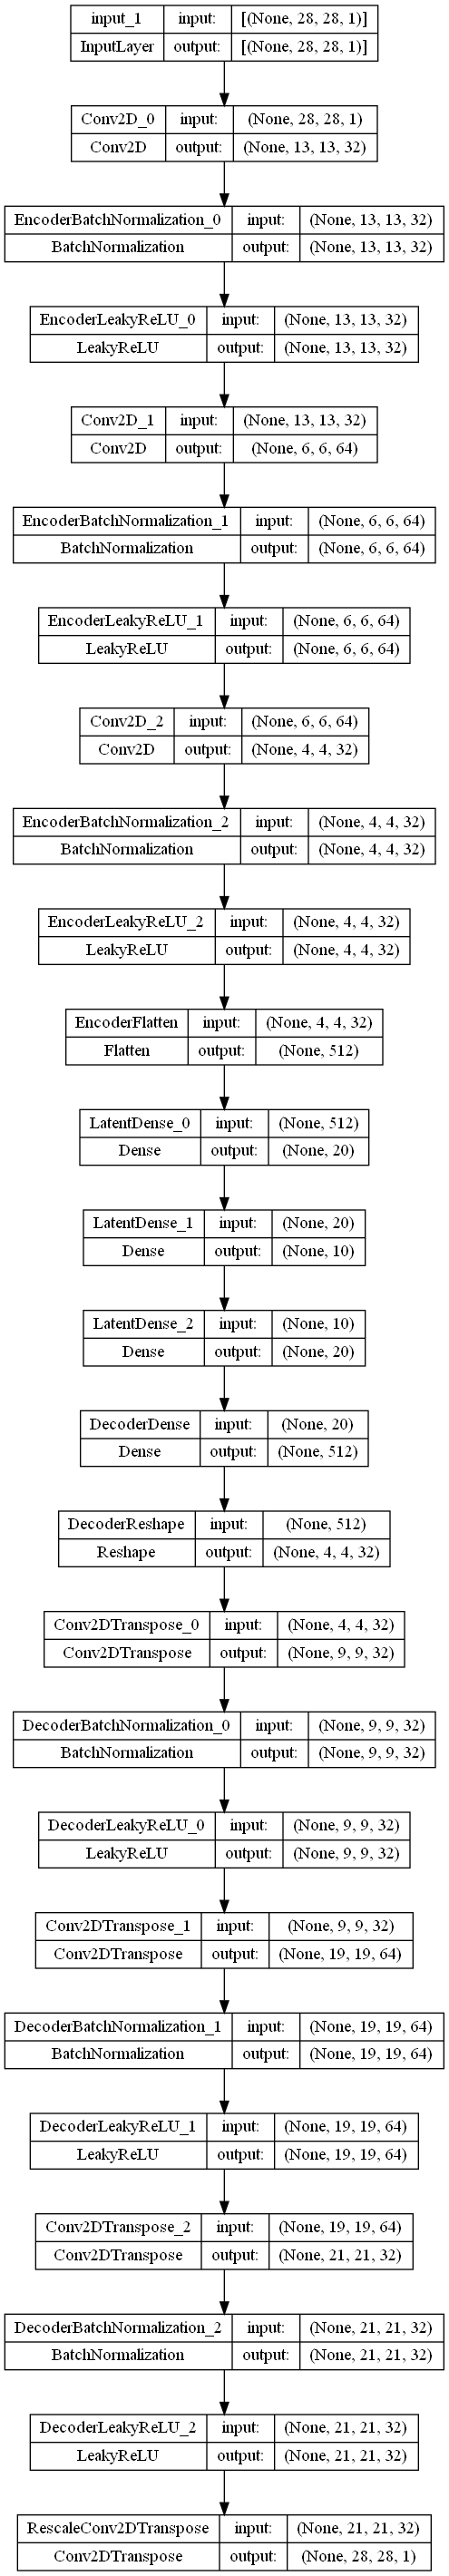

In [5]:
input = Input((28,28,1))
encoder = Encoder()
latent = Latent(encoder)
decoder = Decoder(latent)

autoencoder = Model(inputs = input, outputs = decoder.call(latent.call(encoder.call(input))))


plot_model(autoencoder, show_shapes=True, show_layer_names=True)

# Main

In [6]:
data = pd.read_csv('Data/mnist_train_small.csv')
data = data.drop('label', axis = 1).to_numpy()

# Normalize the data to a range of [0 1] and convert to float
data = data.astype('float32') / 255.0

x_train = data.reshape(data.shape[0],28,28,1)

In [7]:
# Compile the autoencoder modelS
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder model
history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=32)

Epoch 1/10
625/625 [==============================] - 28s 40ms/step - loss: 0.0577
Epoch 2/10
625/625 [==============================] - 25s 39ms/step - loss: 0.0368
Epoch 3/10
625/625 [==============================] - 25s 39ms/step - loss: 0.0320
Epoch 4/10
625/625 [==============================] - 25s 40ms/step - loss: 0.0288
Epoch 5/10
625/625 [==============================] - 25s 40ms/step - loss: 0.0270
Epoch 6/10
625/625 [==============================] - 25s 40ms/step - loss: 0.0252
Epoch 7/10
625/625 [==============================] - 25s 40ms/step - loss: 0.0238
Epoch 8/10
625/625 [==============================] - 25s 40ms/step - loss: 0.0227
Epoch 9/10
625/625 [==============================] - 24s 39ms/step - loss: 0.0219
Epoch 10/10
625/625 [==============================] - 24s 38ms/step - loss: 0.0213


# Show results

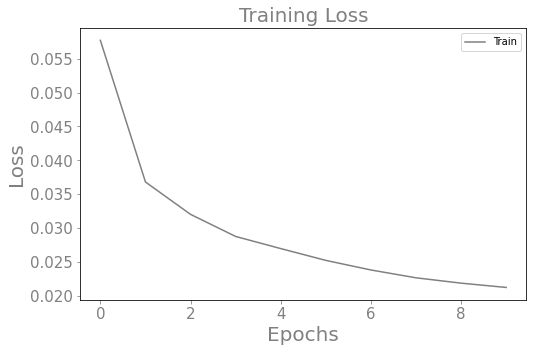

In [8]:
fig, axs = plt.subplots(figsize=(8,5))

axs.plot(history.history['loss'], color = 'gray')
axs.set_title('Training Loss', color = 'gray',fontsize =20)
axs.set_xlabel('Epochs', color = "gray", fontsize =20)
axs.set_ylabel('Loss', color = "gray", fontsize =20)
axs.tick_params(axis ='both', colors = 'gray', labelsize = 15)
axs.legend(['Train'])

plt.show()

In [10]:
img = autoencoder.predict(x_train)

625/625 [==============================] - 10s 16ms/step


In [16]:
img[8].shape

(28, 28, 1)

625/625 [==============================] - 11s 17ms/step


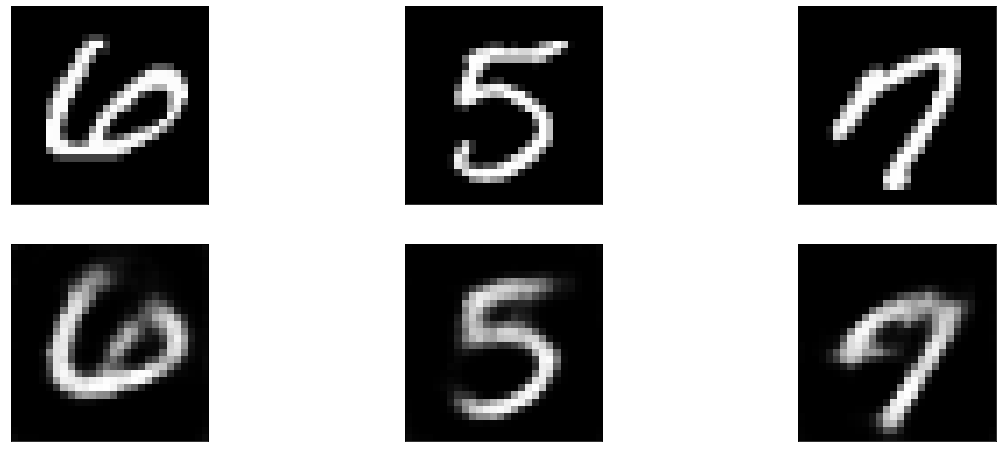

In [9]:

n = 3
plt.figure(figsize=(20, 8))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Reconstructed images
    autoencoder.predict(x_train)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(autoencoder.predict(x_train)[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()